In [1]:
import csv
import random
from faker import Faker
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

class Materia:
    """Clase que representa una materia académica"""
    def __init__(self, nombre, nota=0):
        self.nombre = nombre
        self.nota = nota

    def __str__(self):
        return f"{self.nombre}: {self.nota}"

    def aprobada(self):
        """Determina si la materia está aprobada (nota >= 6)"""
        return self.nota >= 6

class Estudiante:
    """Clase que representa un estudiante y sus calificaciones"""
    def __init__(self, nombre, apellido, materias):
        self.nombre = nombre
        self.apellido = apellido
        self.materias = {m.nombre: m for m in materias}

    def promedio_general(self):
        """Calcula el promedio general del estudiante"""
        notas = [m.nota for m in self.materias.values()]
        return sum(notas) / len(notas) if notas else 0

    def materias_aprobadas(self):
        """Retorna la cantidad de materias aprobadas"""
        return sum(1 for m in self.materias.values() if m.aprobada())

    def __str__(self):
        return (f"Estudiante: {self.nombre} {self.apellido}\n"
                f"Promedio: {self.promedio_general():.2f}\n"
                f"Materias aprobadas: {self.materias_aprobadas()}/{len(self.materias)}")

def generar_csv_estudiantes():
    """Genera un archivo CSV con datos aleatorios de estudiantes y sus notas"""
    fake = Faker('es_ES')
    materias = ['matemáticas', 'física', 'química', 'biología', 'literatura',
                'historia', 'geografía', 'economía', 'inglés', 'artes', 'edu_fisica']

    while True:
        try:
            num_estudiantes = int(input("Ingrese la cantidad de estudiantes a generar: "))
            if num_estudiantes <= 0:
                print("Por favor ingrese un número mayor que 0.")
                continue
            break
        except ValueError:
            print("Error: Debe ingresar un número entero válido.")

    archivo_csv = 'estudiantes_notas.csv'

    with open(archivo_csv, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['nombre', 'apellido'] + materias)
        writer.writeheader()

        for _ in range(num_estudiantes):
            estudiante = {
                'nombre': fake.first_name(),
                'apellido': fake.last_name()
            }
            for materia in materias:
                estudiante[materia] = random.randint(0, 10)
            writer.writerow(estudiante)

    print(f"\nArchivo '{archivo_csv}' generado con éxito con {num_estudiantes} estudiantes.")
    return archivo_csv

def procesar_csv(ruta_csv):
    """Procesa el CSV y crea instancias de Estudiante con sus Materias"""
    estudiantes = []

    with open(ruta_csv, mode='r', encoding='utf-8') as file:
        reader = csv.DictReader(file)
        materias_disponibles = [field for field in reader.fieldnames if field not in ['nombre', 'apellido']]

        for row in reader:
            materias = [Materia(nombre, int(row[nombre])) for nombre in materias_disponibles]
            estudiantes.append(Estudiante(row['nombre'], row['apellido'], materias))

    return estudiantes

def mostrar_rendimiento(estudiantes):
    """Muestra el rendimiento académico de los estudiantes"""
    print("\n=== RENDIMIENTO ACADÉMICO ===")
    for i, estudiante in enumerate(estudiantes, 1):
        print(f"\nEstudiante #{i}")
        print(estudiante)
        print("Detalle de materias:")
        for materia in estudiante.materias.values():
            print(f"- {materia.nombre}: {materia.nota} {'(Aprobada)' if materia.aprobada() else '(Reprobada)'}")

def calcular_estadisticas_grupo(estudiantes):
    """Calcula y muestra estadísticas generales del grupo"""
    if not estudiantes:
        print("\nNo hay estudiantes para calcular estadísticas.")
        return

    print("\n=== ESTADÍSTICAS GENERALES DEL GRUPO ===")

    materias_grupo = list(estudiantes[0].materias.keys())

    # Promedio por asignatura
    print("\nPromedio por asignatura:")
    promedios_asignaturas = {}
    for materia in materias_grupo:
        total = sum(e.materias[materia].nota for e in estudiantes)
        promedio = total / len(estudiantes)
        promedios_asignaturas[materia] = promedio
        print(f"- {materia.capitalize()}: {promedio:.2f}")

    # Porcentaje de aprobación general
    print("\nPorcentaje de aprobación general:")
    total_materias = len(materias_grupo) * len(estudiantes)
    aprobadas = sum(1 for e in estudiantes for m in e.materias.values() if m.aprobada())
    porcentaje_aprobacion = (aprobadas / total_materias) * 100 if total_materias > 0 else 0
    print(f"- {porcentaje_aprobacion:.2f}% de aprobación en todo el grupo")

    # Asignaturas con mayor y menor rendimiento
    print("\nAsignaturas con mayor y menor rendimiento:")
    materia_max = max(promedios_asignaturas.items(), key=lambda x: x[1])
    materia_min = min(promedios_asignaturas.items(), key=lambda x: x[1])
    print(f"- Mayor rendimiento: {materia_max[0].capitalize()} (promedio: {materia_max[1]:.2f})")
    print(f"- Menor rendimiento: {materia_min[0].capitalize()} (promedio: {materia_min[1]:.2f})")
    print("\n")

def generar_graficos_distribucion(estudiantes):
    """Genera gráficos de distribución normal por materia mostrando el promedio"""
    if not estudiantes:
        print("\nNo hay datos para generar gráficos.")
        return

    materias_grupo = list(estudiantes[0].materias.keys())
    promedios = {}
    datos_materias = {materia: [] for materia in materias_grupo}

    # Recolectar datos
    for estudiante in estudiantes:
        for materia in materias_grupo:
            datos_materias[materia].append(estudiante.materias[materia].nota)

    # Calcular promedios y desviaciones estándar
    for materia in materias_grupo:
        notas = datos_materias[materia]
        promedios[materia] = (np.mean(notas), np.std(notas))

    # Configurar estilo de los gráficos
    plt.style.use('seaborn-v0_8')

    # Generar un gráfico por materia
    for materia, (promedio, std_dev) in promedios.items():
        plt.figure(figsize=(10, 6))

        # Crear distribución normal teórica
        x = np.linspace(0, 10, 1000)
        y = norm.pdf(x, promedio, std_dev)

        # Graficar
        plt.plot(x, y, 'b-', linewidth=2, label='Distribución teórica')
        plt.fill_between(x, y, color='blue', alpha=0.1)

        # Graficar histograma de datos reales
        plt.hist(datos_materias[materia], bins=10, density=True,
                alpha=0.5, color='green', label='Datos reales')

        # Línea vertical para el promedio
        plt.axvline(promedio, color='red', linestyle='--',
                   linewidth=2, label=f'Promedio: {promedio:.2f}')

        # Configuración del gráfico
        plt.title(f'Distribución de notas en {materia.capitalize()}\n'
                 f'Promedio: {promedio:.2f} - Desviación estándar: {std_dev:.2f}')
        plt.xlabel('Notas')
        plt.ylabel('Densidad')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 10)

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()


Archivo 'estudiantes_notas.csv' generado con éxito con 15 estudiantes.

=== RENDIMIENTO ACADÉMICO ===

Estudiante #1
Estudiante: Eduardo Granados
Promedio: 6.09
Materias aprobadas: 6/11
Detalle de materias:
- matemáticas: 10 (Aprobada)
- física: 8 (Aprobada)
- química: 0 (Reprobada)
- biología: 4 (Reprobada)
- literatura: 9 (Aprobada)
- historia: 10 (Aprobada)
- geografía: 5 (Reprobada)
- economía: 8 (Aprobada)
- inglés: 4 (Reprobada)
- artes: 9 (Aprobada)
- edu_fisica: 0 (Reprobada)

Estudiante #2
Estudiante: Candelaria Barrena
Promedio: 5.64
Materias aprobadas: 5/11
Detalle de materias:
- matemáticas: 3 (Reprobada)
- física: 4 (Reprobada)
- química: 10 (Aprobada)
- biología: 3 (Reprobada)
- literatura: 9 (Aprobada)
- historia: 0 (Reprobada)
- geografía: 2 (Reprobada)
- economía: 9 (Aprobada)
- inglés: 10 (Aprobada)
- artes: 9 (Aprobada)
- edu_fisica: 3 (Reprobada)

Estudiante #3
Estudiante: Montserrat Pedro
Promedio: 5.18
Materias aprobadas: 5/11
Detalle de materias:
- matemáticas: 

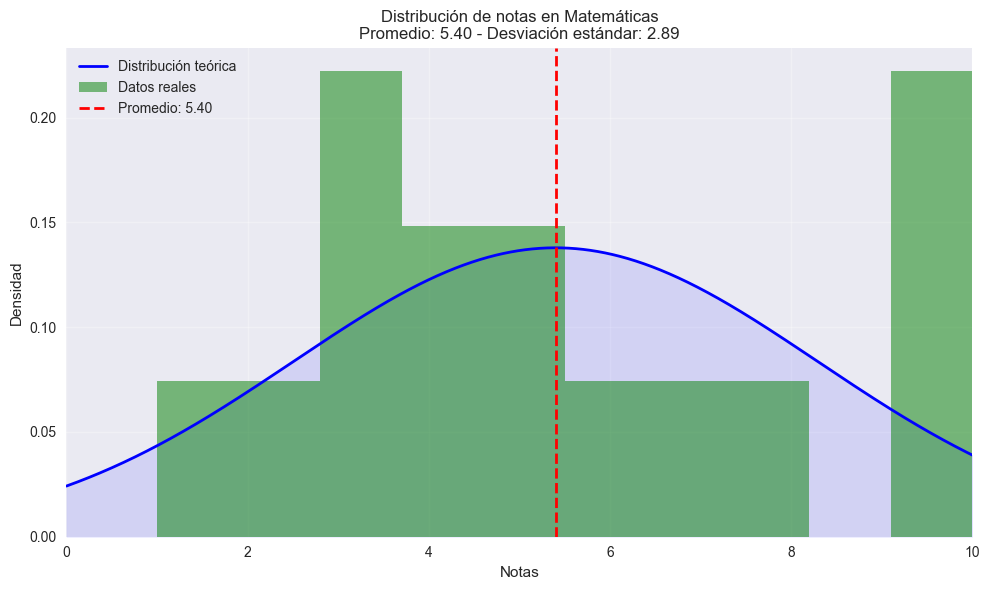

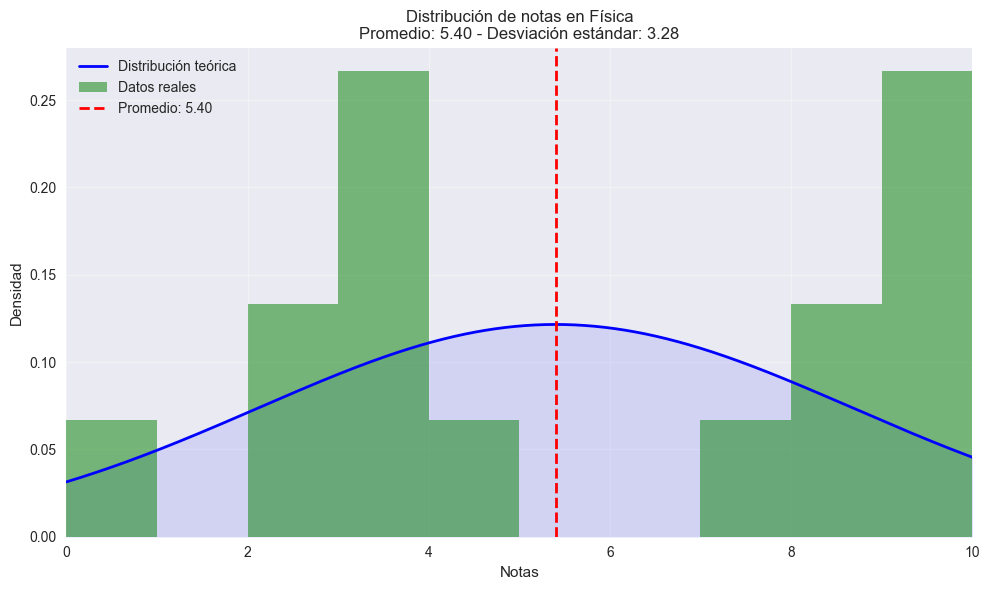

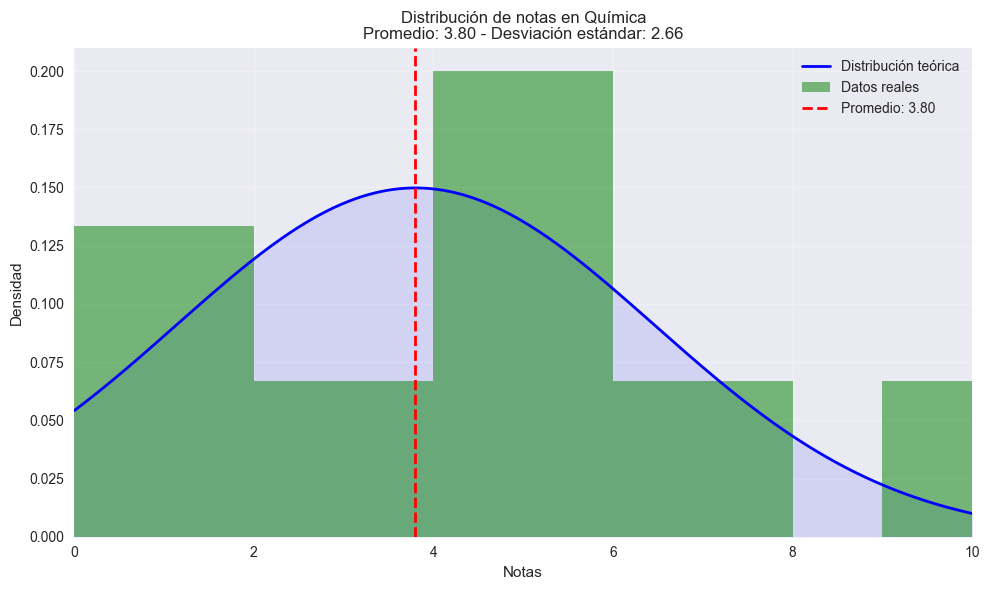

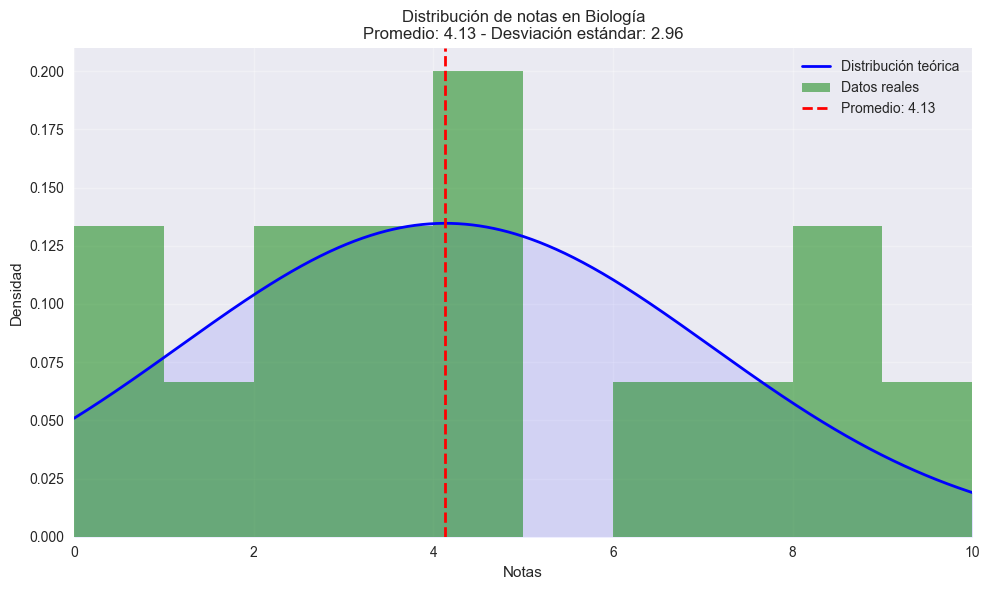

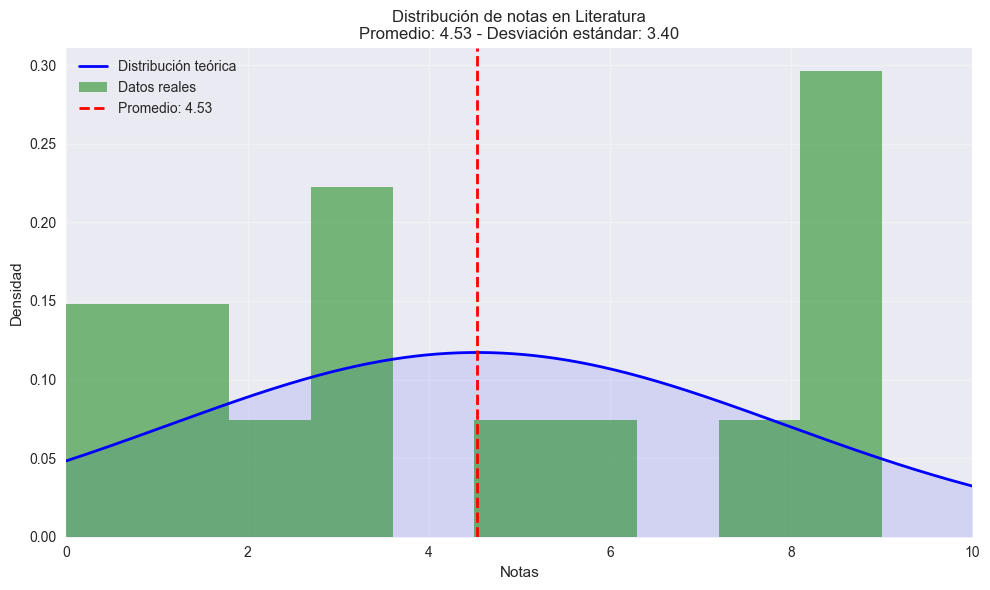

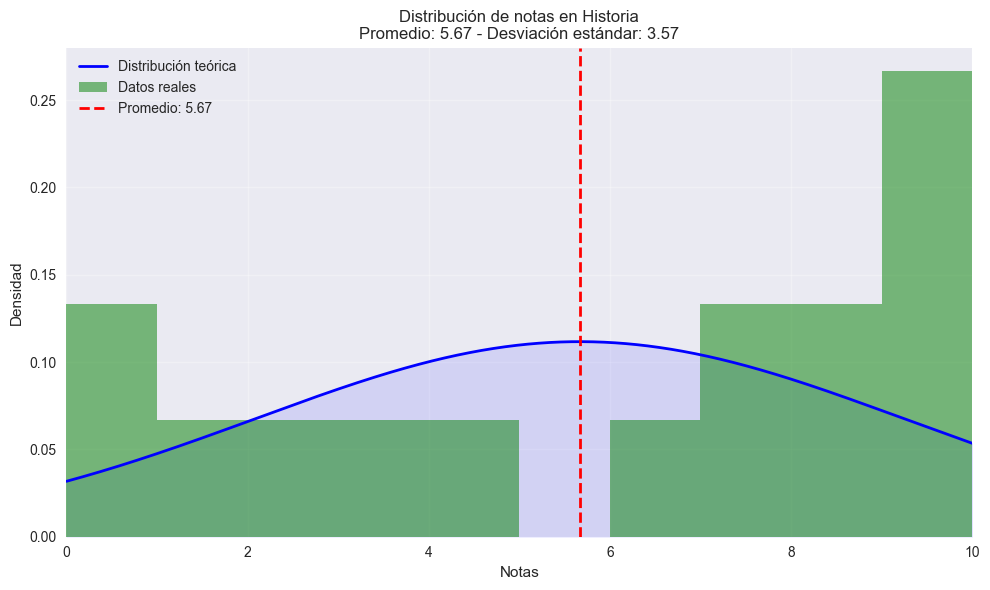

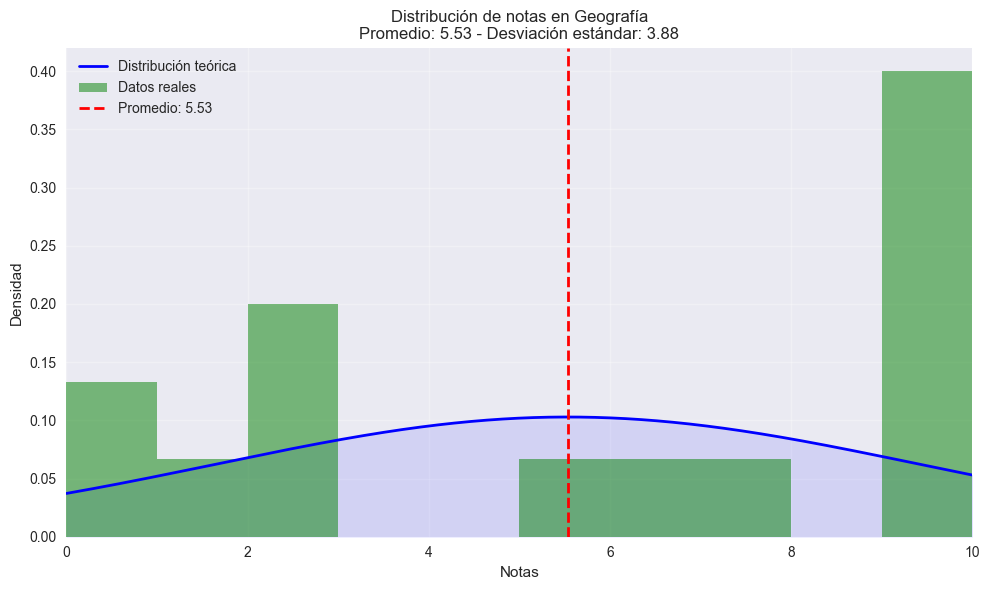

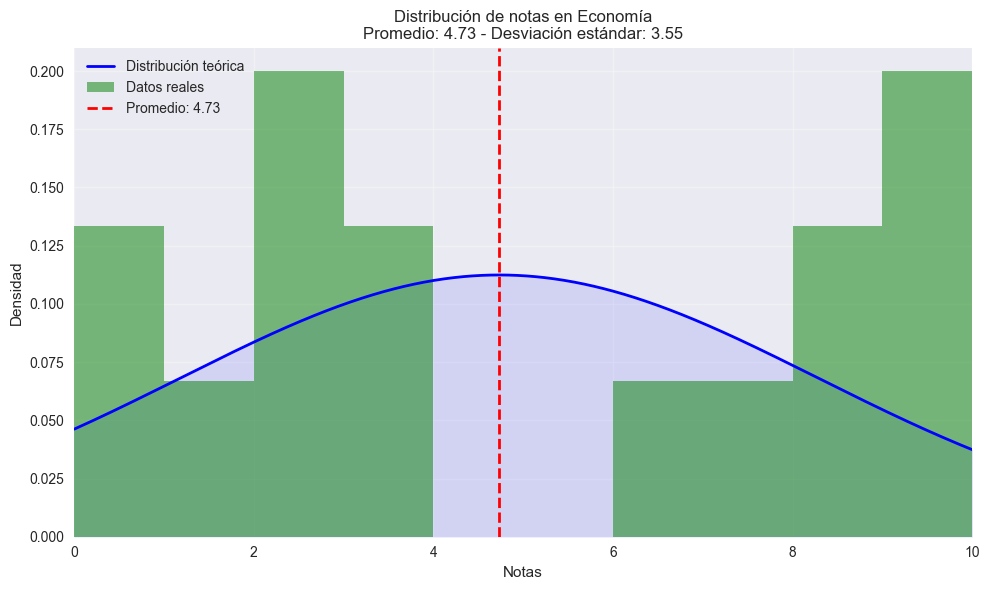

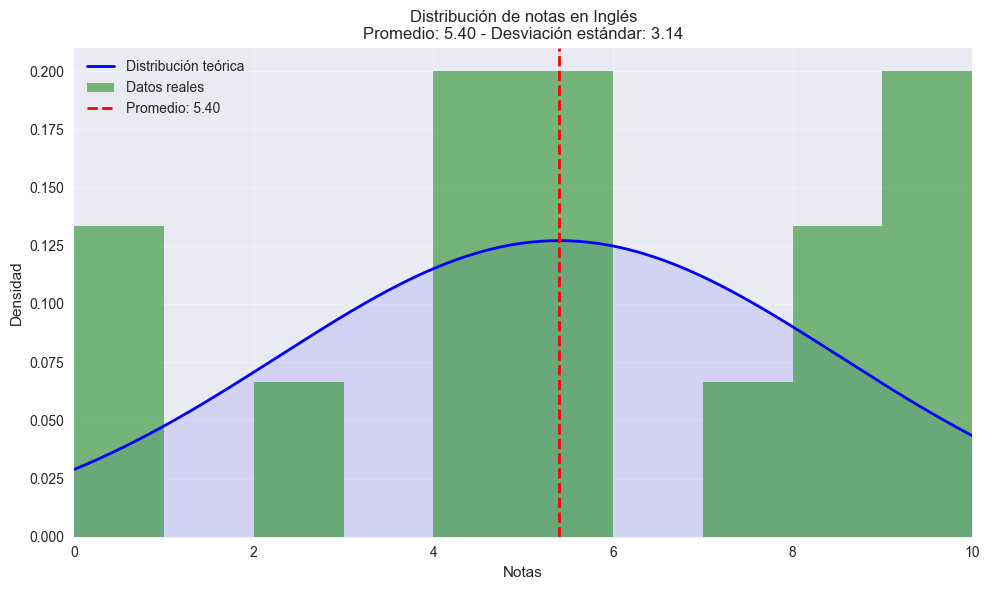

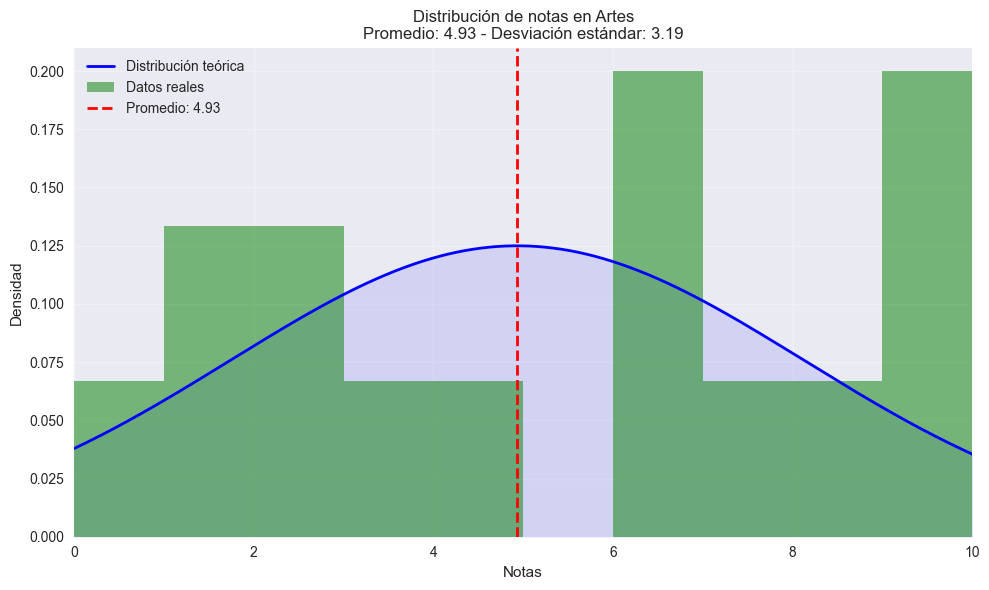

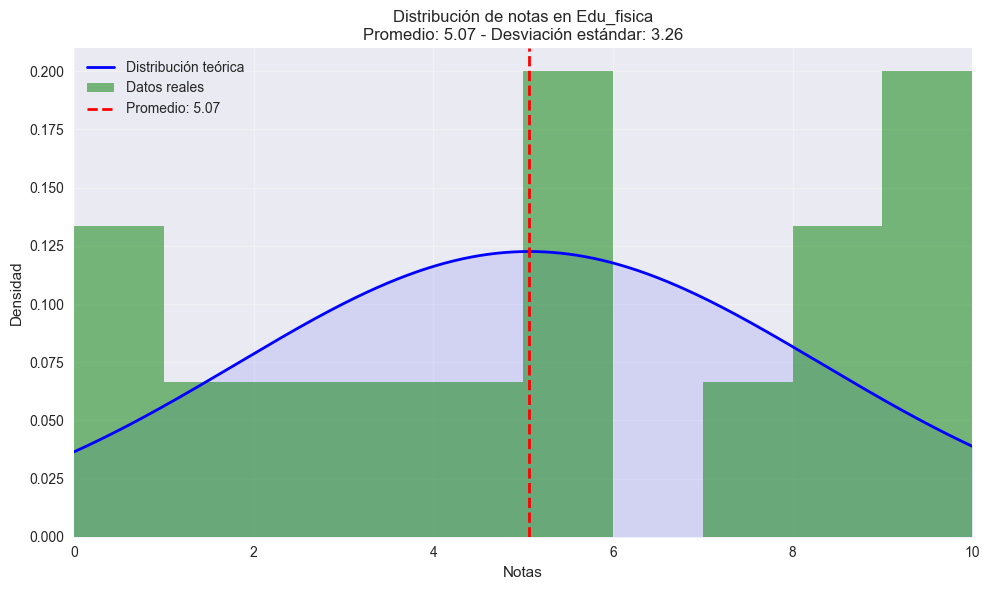

In [2]:
if __name__ == "__main__":
    # Generar CSV y procesarlo
    archivo = generar_csv_estudiantes()
    lista_estudiantes = procesar_csv(archivo)

    # Mostrar resultados individuales
    mostrar_rendimiento(lista_estudiantes)

    # Mostrar estadísticas adicionales
    calcular_estadisticas_grupo(lista_estudiantes)

    # Generar gráficos de distribución
    generar_graficos_distribucion(lista_estudiantes)